1. В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.).
2. Для задачи классификации обучить дерево решений с использованием критериев разбиения Джини и Энтропия. Сравнить качество классификации, сделать выводы.
3. [опция]. Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.

-----

Есть желание полностью переписать код, заимствуя некоторые моменты. Отдельно выделю фрагменты, необходимые по заданию.

In [1]:
from sklearn import datasets

import numpy as np
from matplotlib import pyplot as plt
from sklearn import model_selection
from matplotlib.colors import ListedColormap

Вспомогательные классы, которые олицетворяют ветки дедева и его конечные узлы - листья:

In [222]:
class Node:
    '''
    Узел решающего дерева, храняющий определитель признака и порогового значения, а также
    направления на следующие узлы.
    '''
    def __init__(self, index, thershold, true_branch, false_branch):
        self.index = index  # индекс признака
        self.thershold = thershold
        self.true_branch = true_branch
        self.false_branch = false_branch


class Leaf:
    '''
    Узлы, в которых происходит выдача предсказания и дальше дерево не строится
    '''
    def __init__(self, data, labels, prediction_type):
        self.data = np.array(data)
        self.labels = np.array(labels)
        self.prediction_type = prediction_type
        self.prediction = self.predict()
        
    def predict(self):
        if self.prediction_type == 'classification':
            classes, labels_cnt = np.unique(self.labels, return_counts=True)
            prediction = classes[labels_cnt == labels_cnt.max()][0]
        elif self.prediction_type == 'regression':
            prediction = self.labels.mean()
        return prediction

Основной класс с описанием решающего дерева:

In [301]:
class DecisionTree:
    '''
    Классификатор или регрессор, построенный на алгоритме решающего дерева.
    
    
    Parameters:
    -----------
    predict_type: str {"classification", "regression"}
        Тип решаемой задачи алгоритмом. По умолчанию "classification"
    max_depth: int
        Максимальная глубина дерева.
    min_leaf: int
        Минимальное число объектов на одном листе дерева.
    criterion: {"gini", "entropy"}
        Критерий разбиения значения в разные узлы для классификации.
        Для задачи регрессии используется оценка дисперсии признаков и атрибут не учитывается.
    max_leafes_number: int
        Максимальное число листьев. В текущей реализации возможны случаи,
        когда количество листьев будет несколько выше указанного значения.
    
    '''
    def __init__(self,
                 predict_type: str='classification',
                 max_depth: int=None,
                 min_leaf: int=1,
                 criterion: str='gini',
                 max_leafes_number: int=None):
        # перечисленные параметры являются параметрами останова, настраиваемыми далее. 1 задание
        self.__predict_type = predict_type
        self.__max_depth = max_depth
        self.__min_leaf = min_leaf
        if predict_type == 'regression':
            criterion = 'variance'
        self.__criterion = criterion
        self.__max_leafes_number = max_leafes_number
        self.__n_leafs = 0
    
    def _gini(self, labels: np.array):
        '''
        Расчет порогового значения в узле(Node) на основании критерия Джини.
        Первая часть 2 задания
        '''        
        labels = np.array(labels)
        classes, size = np.unique(labels, return_counts=True)
        impurity = 1 - ((size / labels.shape)**2).sum()
        return impurity
        
    def _entropy(self, labels: np.array):
        '''
        Расчет порогового значения в узле(Node) на основании энтропии.
        Первая часть 2 задания
        '''
        labels = np.array(labels)
        classes, size = np.unique(labels, return_counts=True)
        p = size / labels.shape
        impurity = - (p * np.log2(p)).sum()
        return impurity

    def _variance(self, labels: np.array):
        '''
        Расчет порогового значения в узле(Node) на основании дисперсии целевой переменной.
        3 задание
        '''
        labels = np.array(labels)
        M_x = labels.mean()
        impurity = ((labels - M_x)**2).mean()
        return impurity
    
    def _quality(self, left_labels, right_labels, criteria_current):
        p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
        if self.__criterion == 'gini':
            criteria = self._gini
        elif self.__criterion == 'entropy':
            criteria = self._entropy
        elif self.__criterion == 'variance':
            criteria = self._variance
        return criteria_current - p * criteria(left_labels) - (1 - p) * criteria(right_labels)
    
    def _split(self, data, labels, index, t):
        left = np.where(data[:, index] <= t)
        right = np.where(data[:, index] > t)

        true_data = data[left]
        false_data = data[right]
        true_labels = labels[left]
        false_labels = labels[right]

        return true_data, false_data, true_labels, false_labels
    
    def _find_best_split(self, data, labels):
        if self.__criterion == 'gini':
            criteria = self._gini
        elif self.__criterion == 'entropy':
            criteria = self._entropy
        elif self.__criterion == 'variance':
            criteria = self._variance
            
        criteria_current = criteria(labels)

        best_quality = 0
        best_t = None
        best_index = None

        n_features = data.shape[1]

        for index in range(n_features):
            t_values = np.unique(data[:, index])

            for t in t_values:
                true_data, false_data, true_labels, false_labels = self._split(data, labels, index, t)
                if min(len(true_data), len(false_data)) < self.__min_leaf:
                    continue

                current_quality = self._quality(true_labels, false_labels, criteria_current)

                if current_quality > best_quality:
                    best_quality, best_t, best_index = current_quality, t, index

        return best_quality, best_t, best_index
    
    def _build_tree(self, data, labels, depth=0):
        quality, t, index = self._find_best_split(data, labels)

        if quality == 0 or (self.__max_depth is not None and depth >= self.__max_depth)\
        or (self.__max_leafes_number is not None and self.__n_leafs >= self.__max_leafes_number - 1):
            self.__n_leafs += 1
            return Leaf(data, labels, self.__predict_type)

        true_data, false_data, true_labels, false_labels = self._split(data, labels, index, t)
        
        true_branch = self._build_tree(true_data, true_labels, depth + 1)
        false_branch = self._build_tree(false_data, false_labels, depth + 1)

        return Node(index, t, true_branch, false_branch)
    
    def _classify_object(self, obj, node):
        if isinstance(node, Leaf):
            answer = node.prediction
            return answer

        if obj[node.index] <= node.thershold:
            return self._classify_object(obj, node.true_branch)
        else:
            return self._classify_object(obj, node.false_branch)
    
    def fit(self, X, y):
        '''
        Обучает модель.
        
        Parameters:
        -----------
        X, y: array like
            Значения признаков и целевой переменной
        '''
        self.__tree = self._build_tree(X, y)
    
    def predict(self, X):
        '''
        Отдает предсказания обученной модели.
        
        Parameters:
        -----------
        X: array like
            Значения признаков
        
        Returns
        -------
        X: np.array
            Предсказанные значения
        '''
        classes = []
        for obj in X:
            prediction = self._classify_object(obj, self.__tree)
            classes.append(prediction)
        return classes
    
    def fit_predict(self, X, y):
        '''
        Обучает модель и отдает ее предсказания.
        
        Parameters:
        -----------
        X, y: array like
            Значения признаков и целевой переменной
        
        Returns
        -------
        X: np.array
            Предсказанные значения
        '''
        self.fit(X, y)
        return self.predict(X)

Вспомогательные функции подсчета метрик и создания плоскости разбиения результатов предсказания:

In [199]:
def accuracy_metric(actual, predicted):
    return (actual == predicted).sum() / actual.shape[0]

def mae_metric(actual, predicted):
    return ((actual - predicted)**2).mean()

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

----

1) Составим датасет с имитацией классификации и обучим 2 базовые модели (с минимальным количеством значений в узле равным 6 и максимальной глубиной 3) с разными критериями выбора порогов:

In [335]:
data, labels = datasets.make_classification(n_samples=300, n_features=2, n_redundant=0)

X_train, X_test, y_train, y_test = model_selection.train_test_split(data, labels, test_size=0.3)

In [336]:
model_gini = DecisionTree(criterion='gini', min_leaf=6, max_depth=3)
model_entropy = DecisionTree(criterion='entropy', min_leaf=6, max_depth=3)

pred_gini = model_gini.fit_predict(X_train, y_train)
pred_entropy = model_entropy.fit_predict(X_train, y_train)

pred_gini_test = model_gini.predict(X_test)
pred_entropy_test = model_entropy.predict(X_test)


In [337]:
train_data = np.vstack([X_train.T, y_train]).T
test_data = np.vstack([X_test.T, y_test]).T

<ipython-input-338-5896c78735f4>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = ListedColormap(['lightcoral', 'lightblue']))
<ipython-input-338-5896c78735f4>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = ListedColormap(['lightcoral', 'lightblue']))


Text(0.5, 1.0, 'Test accuracy=0.97')

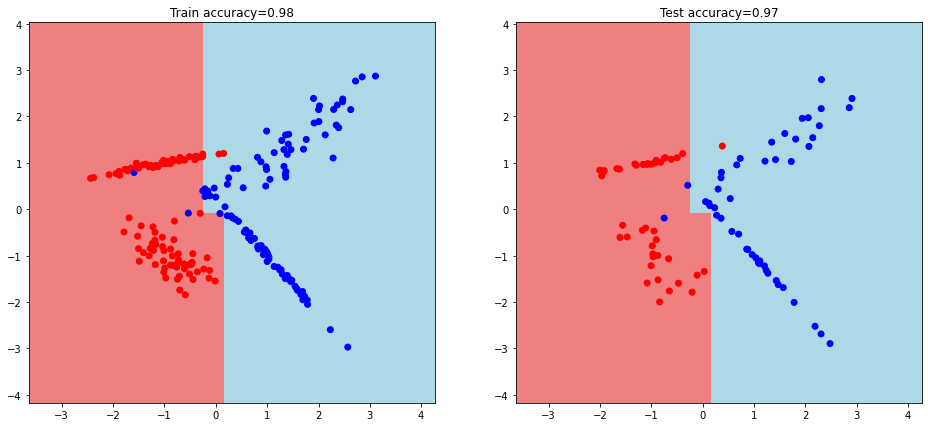

In [338]:
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(model_gini.predict(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = ListedColormap(['lightcoral', 'lightblue']))
plt.scatter(train_data[:, 0], train_data[:, 1], c = y_train, cmap = ListedColormap(['red', 'blue']))
plt.title(f'Train accuracy={accuracy_metric(y_train, pred_gini):.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = ListedColormap(['lightcoral', 'lightblue']))
plt.scatter(test_data[:, 0], test_data[:, 1], c = y_test, cmap = ListedColormap(['red', 'blue']))
plt.title(f'Test accuracy={accuracy_metric(y_test, pred_gini_test):.2f}')

-----

2) Оценим разницу в метриках между использованием разных критериев:

In [339]:
print('Значения accuracy для test:')
print(f'\tGini: \t\t{round(accuracy_metric(y_train, pred_gini), 5)}')
print(f'\tEntropy: \t{round(accuracy_metric(y_train, pred_entropy), 5)}')
print('Значения accuracy для train:')
print(f'\tGini: \t\t{round(accuracy_metric(y_test, pred_gini_test), 5)}')
print(f'\tEntropy: \t{round(accuracy_metric(y_test, pred_entropy_test), 5)}')

Значения accuracy для test:
	Gini: 		0.97619
	Entropy: 	0.97619
Значения accuracy для train:
	Gini: 		0.96667
	Entropy: 	0.96667


В данном примере особой разницы по метрикам нет.

Т.к. модель учится на 2 признаках, можно построить двумерный график с разбитием на области предсказания и рассмотреть разницу выбора критерия: 

In [340]:
model_gini_area = DecisionTree(criterion='gini', min_leaf=1)
model_entropy_area = DecisionTree(criterion='entropy', min_leaf=1)

model_gini_area.fit(X_train, y_train)
model_entropy_area.fit(X_train, y_train)


<ipython-input-341-30a03b4672e5>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions_gini, cmap = ListedColormap(['lightcoral', 'lightblue']))
<ipython-input-341-30a03b4672e5>:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions_entropy, cmap = ListedColormap(['lightcoral', 'lightblue']))


Text(0.5, 1.0, 'Зоны предсказаний для критерия энтропии')

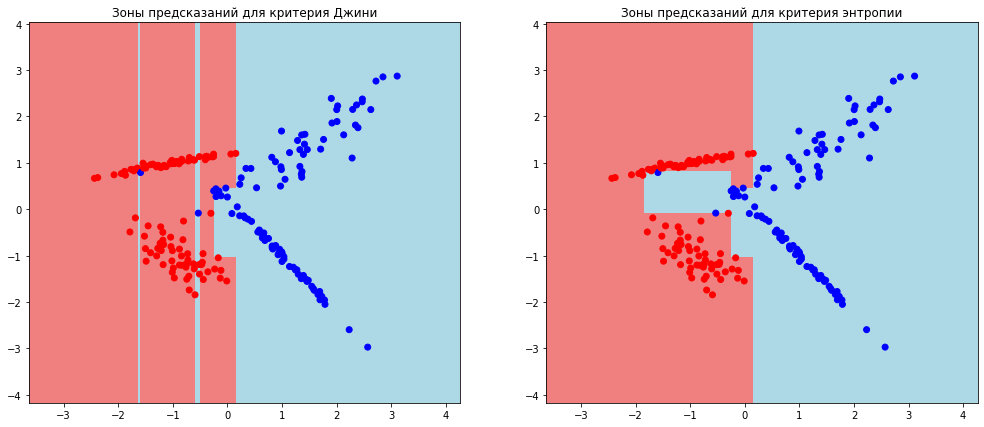

In [341]:
xx, yy = get_meshgrid(train_data)
mesh_predictions_gini = np.array(model_gini_area.predict(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
mesh_predictions_entropy = np.array(model_entropy_area.predict(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)

plt.figure(figsize = (17, 7))

# Gini
plt.subplot(1,2,1)
plt.pcolormesh(xx, yy, mesh_predictions_gini, cmap = ListedColormap(['lightcoral', 'lightblue']))
plt.scatter(train_data[:, 0], train_data[:, 1], c = y_train, cmap = ListedColormap(['red', 'blue']))
plt.title('Зоны предсказаний для критерия Джини')

# entropy
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions_entropy, cmap = ListedColormap(['lightcoral', 'lightblue']))
plt.scatter(train_data[:, 0], train_data[:, 1], c = y_train, cmap = ListedColormap(['red', 'blue']))
plt.title('Зоны предсказаний для критерия энтропии')


Для более наглядной картины построено дерево с максимальной глубиной (максимальным переобучением). Как видно, сильно выдающейся разницы между использованием двух разных критериев нет. Однако есть некоторое различие в предсказаниях при околонулевых значениях признаков (то есть на границе раздела классов).

-----

3) Алгоритм решающих деревьев можно применять не только для задач классификации, но и регрессии. Воспроизведем его, используя в качестве критерия выявления порога значение дисперсии.

In [342]:
data_regr, labels_regr = datasets.make_regression(n_samples=400, n_features=10, n_informative=8, noise=50)

X_train_regr, X_test_regr, y_train_regr, y_test_regr = model_selection.train_test_split(data_regr, labels_regr, test_size=0.3)

In [343]:
model_regression = DecisionTree(predict_type='regression', min_leaf=10, max_depth=100)

pred_regr_train = model_regression.fit_predict(X_train_regr, y_train_regr)

pred_regr_test = model_regression.predict(X_test_regr)

In [344]:
mae_train = mae_metric(y_train_regr, pred_regr_train)**0.5
mae_test = mae_metric(y_test_regr, pred_regr_test)**0.5

print(f'train выборка:')
print(f'\tКорень из MAE:   {round(mae_train, 5)}')
print(f'\tСреднее выборке: {round(y_train_regr.mean(), 5)}')
print(f'test выборка:')
print(f'\tКорень из MAE:   {round(mae_test, 5)}')
print(f'\tСреднее выборке: {round(y_test_regr.mean(), 5)}')

train выборка:
	Корень из MAE:   69.37978
	Среднее выборке: 5.8162
test выборка:
	Корень из MAE:   113.71086
	Среднее выборке: 16.54835


Здесь значения метрики получились не очень воодушевляющие. Но получились.